In [1]:
# Import libraries

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load datasets

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

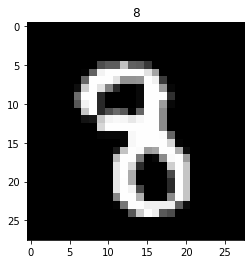

In [3]:
# Data exploration

idx = torch.randint(len(training_data), size=(1,)).item()
label = training_data[idx][1]
image = training_data[idx][0]

plt.title(label)
plt.imshow(image.squeeze(), cmap='gray')

plt.show()

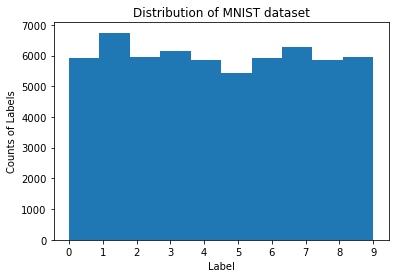

In [4]:
all_labels = []

for img, label in training_data:
    all_labels.append(label)

plt.hist(all_labels)
plt.title('Distribution of MNIST dataset')
plt.xlabel('Label')
plt.ylabel('Counts of Labels')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

plt.show()

## Implementing a Convolutional Neural Network (CNN) with PyTorch

In [5]:
# Build the model
# https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/

from torch.nn import Module     # A subclass of Sequential
from torch.nn import Conv2d     # A 2D Convolutional layer
from torch.nn import Linear     # A fully connected layer
from torch.nn import MaxPool2d  # Applies 2D max-pooling
from torch.nn import ReLU       # ReLU activation function
from torch.nn import LogSoftmax # The softmax activation function
from torch import flatten       # Flattens a multi-dimensional volume,
                                # so that fully-connected layers can 
                                # be applied to it

class LeNet(Module): # Creates a subclass of the Module object, so we have more control
    
    '''
    numChannels = 1 for grayscale and = 3 for color
    
    classes = num of unique class labels in the dataset
    
    This function simply initializes all the placeholders, but no 
    architecture has been created yet
    '''
    def __init__(self, numChannels, classes):
        # call the parent constructor - Performs several PyTorch-specific setup operations
        super(LeNet, self).__init__()

        # initialize first set of CONV => RELU => POOL layers
        '''
        This first Conv layer applies 20 5x5 filters
        ReLu applied to inc the non-linearity in images b/c images are naturally very NON-linear
        - This reduces the linearity imposed by the Conv operation
        Followed by a Max-pooling layer where pool size = 2
        '''
        self.conv1 = Conv2d(in_channels=numChannels, out_channels=20, kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # initialize second set of CONV => RELU => POOL layers
        '''
        This second Conv layer applies 50 5x5 filters
        ReLU applied for same reason as above
        Followed by a Max-pooling layer where pool size = 2
        '''
        self.conv2 = Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # initialize first (and only) set of FC => RELU layers
        '''
        Define fully-connected layer with 800 inputs and 500 output nodes
        ReLU applied for same reasons as above
        '''
        self.fc1 = Linear(in_features=800, out_features=500)
        self.relu3 = ReLU()

        # initialize our softmax classifier
        '''
        Define fullly-connected layer with 500 inputs and 'classes' outputs
        Softmax applied to define end of forward process
        '''
        self.fc2 = Linear(in_features=500, out_features=classes)
        self.logSoftmax = LogSoftmax(dim=1)

    '''
    1) Connects layers defined in the class constructor (__init__)
    2) Defines the actual network architecture
    3) Allows the forward pass to be performed (=> Output)
    4) Due to PyTorch's 'autograd' module, we also can perform 
       automatic differentiation and update our model weights
       
    x: The batch of input data to the whole nn
    '''
    def forward(self, x):
        # pass the input through our first set of CONV => RELU =>
        # POOL layers
        '''
        Connects the x => conv1 => relu1 => maxpool1 => (next) layers
        '''
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        # pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        '''
        Connects the (prev) => conv2 => relu2 => maxpool2 => (next) layers
        '''
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        # flatten the output from the previous layer and pass it
        # through our only set of FC => RELU layers
        '''
        1) Reduces the multi-dimensional tensor, x, to a 1D 'array'
        2) Connect the (prev) => fc1 => relu3 => (next) layers
        '''
        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        
        # pass the output to our softmax classifier to get our output
        # predictions
        '''
        Connects the (prev) => fc2 => logSoftmax => output layers
        '''
        x = self.fc2(x)
        output = self.logSoftmax(x)
        
        # return the output predictions
        return output

## Creating our CNN training script with PyTorch

### Important initializations

In [6]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from sklearn.metrics import classification_report # Displays details of testing_set performance
from torch.utils.data import random_split         # Constructs a random train/test split
from torch.utils.data import DataLoader           # PyTorch utility used to build data pipelines to train the CNN
from torchvision.transforms import ToTensor       # Converts input data into a PyTorch tensor
from torchvision.datasets import KMNIST           # the Kuzushiji-MNISt DataLoader
from torch.optim import Adam                      # The optimizer we'll use for training
from torch import nn                              # PyTorch's nn implementations

import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch
import time


# ======================= IGNORED FROM TUTORIAL - torch.save used instead
# ==== Construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()

# Outputs the serialized model after training
#ap.add_argument("-m", "--model", type=str, required=True, help="path to output trained model")

# The path to our output training history plot
#ap.add_argument("-p", "--plot", type=str, required=True, help="path to output loss/accuracy plot")

# ???
#args = vars(ap.parse_args())
# ======================= IGNORED FROM TUTORIAL - torch.save used instead

# ==== Define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 64 # Number of samples used in each iteration
EPOCHS = 10

# ==== Define the training and validation splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

# set the device we will be using to train the model (cpu vs gpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Preparing the dataset

In [7]:
# load the KMNIST dataset
print("[INFO] loading the KMNIST dataset...")
trainData = KMNIST(root="data", train=True, download=True, transform=ToTensor())
testData  = KMNIST(root="data", train=False, download=True, transform=ToTensor())

# Calculate the train/validation split
print("[INFO] generating the train/validation split...")
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numValSamples = int(len(trainData) * VAL_SPLIT)
(trainData, valData) = random_split(trainData, [numTrainSamples, numValSamples], generator=torch.Generator().manual_seed(42))

# Initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)

# Calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

[INFO] loading the KMNIST dataset...
[INFO] generating the train/validation split...


### Initialize LeNet

In [8]:
# initialize the LeNet model
'''
numChannels = 1 b/c images are grayscale

to(device) moves model to CPU or GPU
'''
print("[INFO] initializing the LeNet model...")
model = LeNet(numChannels=1, classes=len(trainData.dataset.classes)).to(device)

# initialize our optimizer and loss function
'''
Adam optimizer used

NLL == Negative Log Likelihood
- NLL class + LogSoftMax = Categorical Cross-entropy Loss
'''
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.NLLLoss()

# initialize a dictionary to store training history
'''
After every epoch, we will update the dictionary with the below values
'''
H = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

[INFO] initializing the LeNet model...


## Training, validating, and testing the CNN

In [9]:
# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()

# ========================================
# ===== TRAINING AND VALIDATION LOOP =====
# ========================================

# loop over our epochs for training and validating
for e in range(0, EPOCHS):
    # set the model in training mode
    model.train()
    
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    
    # initialize the number of correct predictions in the training and validation steps
    trainCorrect = 0
    valCorrect = 0

    # loop over the training set
    '''
    PyTorch's DataLoader class allows us to simply use a for loop to iterate through a dataset
    
    Any additional data pre-processing or augmentation would occur here
    '''
    for (x, y) in trainDataLoader:
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
    
        # perform a forward pass and calculate the training loss
        pred = model(x)        # The forward pass
        loss = lossFn(pred, y) # Calculation of loss
        
        # zero out the gradients, perform the backpropagation step, and update the weights
        '''
        VERY IMPORTANT - These 3 steps must be performed in this order before doing ANYTHING ELSE
        '''
        opt.zero_grad() # Zeros out the gradients
        loss.backward() # Performs backpropagation
        opt.step()      # Updates model weights

        # add the loss to the total training loss so far and calculate the number of correct predictions
        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
        
    # switch off autograd for evaluation
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        
        # loop over the validation set
        for (x, y) in valDataLoader:
            # send the input to the device
            (x, y) = (x.to(device), y.to(device))
            
            # make the predictions and calculate the validation loss
            pred = model(x)
            totalValLoss += lossFn(pred, y)
            
            # calculate the number of correct predictions
            valCorrect += (pred.argmax(1) == y).type(
                torch.float).sum().item()
            
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    
    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / len(trainDataLoader.dataset)
    valCorrect = valCorrect / len(valDataLoader.dataset)
    
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(valCorrect)
    
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(avgValLoss, valCorrect))
    
# finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

# ========================
# ===== TESTING LOOP =====
# ========================

# we can now evaluate the network on the test set
print("[INFO] evaluating network...")

# turn off autograd for testing evaluation
with torch.no_grad():
    # set the model in evaluation mode
    model.eval()

    # initialize a list to store our predictions
    preds = []
    
    # loop over the test set
    for (x, y) in testDataLoader:
        # send the input to the device
        x = x.to(device)
        
        # make the predictions and add them to the list
        pred = model(x)
        preds.extend(pred.argmax(axis=1).cpu().numpy())

# generate a classification report
print(classification_report(testData.targets.cpu().numpy(), np.array(preds), target_names=testData.classes))

[INFO] training the network...
[INFO] EPOCH: 1/10
Train loss: 0.344964, Train accuracy: 0.8917
Val loss: 0.131555, Val accuracy: 0.9611

[INFO] EPOCH: 2/10
Train loss: 0.093094, Train accuracy: 0.9717
Val loss: 0.093599, Val accuracy: 0.9727

[INFO] EPOCH: 3/10
Train loss: 0.053700, Train accuracy: 0.9835
Val loss: 0.078764, Val accuracy: 0.9772

[INFO] EPOCH: 4/10
Train loss: 0.035285, Train accuracy: 0.9889
Val loss: 0.067579, Val accuracy: 0.9814

[INFO] EPOCH: 5/10
Train loss: 0.022266, Train accuracy: 0.9930
Val loss: 0.090858, Val accuracy: 0.9757

[INFO] EPOCH: 6/10
Train loss: 0.018041, Train accuracy: 0.9939
Val loss: 0.070515, Val accuracy: 0.9816

[INFO] EPOCH: 7/10
Train loss: 0.015539, Train accuracy: 0.9950
Val loss: 0.082226, Val accuracy: 0.9810

[INFO] EPOCH: 8/10
Train loss: 0.009025, Train accuracy: 0.9972
Val loss: 0.074267, Val accuracy: 0.9831

[INFO] EPOCH: 9/10
Train loss: 0.011767, Train accuracy: 0.9961
Val loss: 0.081782, Val accuracy: 0.9792

[INFO] EPOCH: 1

### Display a very detailed classification_report

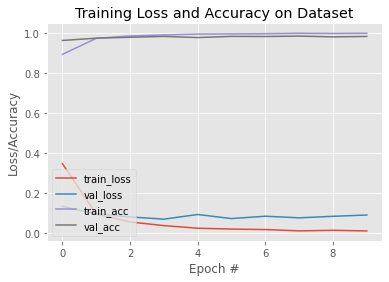

In [17]:
# plot the training + validation loss and accuracy over epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# plt.savefig(args["plot"])

# serialize the model to disk
torch.save(model, r"C:\Users\jandr\0. Tward Lab\model.pth")
# torch.save(model, args["model"])

### Implementing the PyTorch prediction script

In [23]:
# set the numpy seed for better reproducibility
import numpy as np
np.random.seed(42)

# import the necessary packages
from torch.utils.data import DataLoader
from torch.utils.data import Subset         # Builds a subset of test data
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
import argparse
import imutils                              # https://github.com/PyImageSearch/imutils
import torch
import cv2                                  # OpenCV bindings used for displaying output images

In [25]:
# set the device we will be using to test the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the KMNIST dataset and randomly grab 10 data points
print("[INFO] loading the KMNIST test dataset...")
testData = KMNIST(root="data", train=False, download=True,transform=ToTensor())
idxs = np.random.choice(range(0, len(testData)), size=(10,)) # Randomly sample 10 images
testData = Subset(testData, idxs)

# initialize the test data loader
testDataLoader = DataLoader(testData, batch_size=1)

# load the model and set it to evaluation mode
model_loaded = torch.load(r"C:\Users\jandr\0. Tward Lab\model.pth").to(device)
model_loaded.eval()

[INFO] loading the KMNIST test dataset...


LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

### Make predictions on a sample from the test set 

In [ ]:
# switch off autograd
with torch.no_grad():
    # loop over the test set
    for (image, label) in testDataLoader:
        # grab the original image and ground truth label
        origImage = image.numpy().squeeze(axis=(0, 1))
        gtLabel = testData.dataset.classes[label.numpy()[0]]
        
        # send the input to the device and make predictions on it
        image = image.to(device)
        pred = model_loaded(image)
        
        # find the class label index with the largest corresponding probability
        idx = pred.argmax(axis=1).cpu().numpy()[0]
        predLabel = testData.dataset.classes[idx]
        
        # convert the image from grayscale to RGB (so we can draw on
        # it) and resize it (so we can more easily see it on our screen)
        origImage = np.dstack([origImage] * 3)
        origImage = imutils.resize(origImage, width=128)
        
        # draw the predicted class label on it
        color = (0, 255, 0) if gtLabel == predLabel else (0, 0, 255)
        cv2.putText(origImage, gtLabel, (2, 25),
        cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)
        
        # display the result in terminal and show the input image
        print("[INFO] ground truth label: {}, predicted label: {}".format(gtLabel, predLabel))
        cv2.imshow("image", origImage)
        cv2.waitKey(0)

[INFO] ground truth label: ya, predicted label: ya
[INFO] ground truth label: su, predicted label: su
[INFO] ground truth label: ya, predicted label: ya
